### List of augmentations to apply:
Geometric Augmentations:

    - transpose
    - horizontal flip
    - vertical flip
    - elastic transformation/ lens destortion

Color based Augmentations:

    - bubble,
    - stain alter
    - sectioning
    - clahe


### Lung dataset generation:
- take pixel size fixed dataset.
- use artifacts
- use rotation augmentations
- keep the image in its full size

In [1]:
# https://www.kaggle.com/code/bguberfain/elastic-transform-for-data-augmentation/notebook
# https://gist.github.com/erniejunior/601cdf56d2b424757de5
import warnings
warnings.filterwarnings('ignore')
import time
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import staintools
from tqdm import tqdm
import tifffile
import sys
import os
import numpy as np
from scipy import interpolate
from scipy.ndimage import morphology
from scipy.stats import multivariate_normal
from PIL import Image, ImageDraw
from cv2 import GaussianBlur, blur, getPerspectiveTransform, warpPerspective
from hashlib import blake2s
import imgaug as ia
import imgaug.augmenters as iaa
from deconvolution import Deconvolution
import deconvolution.pixeloperations as po
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.transforms import VerticalFlip
from albumentations.augmentations.transforms import Transpose
import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import tifffile
from fastai.vision.all import *
import Augmentor

from collections import defaultdict
sys.path.append("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/histopath_failure_modes")
from image_manipulation import img_manip

In [2]:
TRAIN_CSV = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv"
df = pd.read_csv(TRAIN_CSV)
# df.head()
df_lung = df[df['organ'] == 'lung'].reset_index()
df_lung.__len__(), df['organ'].value_counts()

(48,
 kidney            99
 prostate          93
 largeintestine    58
 spleen            53
 lung              48
 Name: organ, dtype: int64)

In [3]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype = torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    #x = x.transpose(2, 0, 1)
    x = torch.tensor(x, dtype = torch.float)
    return x


# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))


def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask


def cutout_custom(image, mask, alpha=0.05):
    x=int(alpha*image.shape[0])
    y=int(alpha*image.shape[1])
    ctr_list = []
    for i in range(10):
        ctr_list.append(np.random.randint(0,image.shape[0],size=(2)))
    cut_image=np.copy(image)
    cut_mask=np.copy(mask)
    for center in ctr_list:
        cut_image[center[0]-x//2:center[0]+x//2,center[1]-y//2:center[1]+y//2,:]=0
        cut_mask[center[0]-x//2:center[0]+x//2,center[1]-y//2:center[1]+y//2]=0
    return cut_image, cut_mask

def horizontal_flip(image, mask):
    h,w,_ = image.shape
    image = image.reshape(h,w,3)
    mask = mask.reshape(h,w)
    print(image.shape, mask.shape)
    transform = HorizontalFlip(p=1.0)
    augmented_image = transform(image=image, mask=mask)
    image  = augmented_image['image']
    mask  = augmented_image['mask']
    return image, mask

def vertical_flip(image, mask):
    h,w,_ = image.shape
    image = image.reshape(h,w,3)
    mask = mask.reshape(h,w)
    print(image.shape, mask.shape)
    transform = VerticalFlip(p=1.0)
    augmented_image = transform(image=image, mask=mask)
    image  = augmented_image['image']
    mask  = augmented_image['mask']
    return image, mask



def bubble_aug(image, mask):

    im_pil = Image.fromarray(image)
    img_with_bubbles = img_manip.add_bubbles(im_pil, alpha=0.55, maxWidth = 120, nBubbles = 150)
    image = np.array(img_with_bubbles)

    return image, mask



def stain_aug(image, mask):

    im_pil = Image.fromarray(image)
    image_with_stain = img_manip.add_stain(im_pil, adjFactor = [1.5, 0.2, 1.0],scaleMax = [3,3,1.5], scaleMin = [1.25,1.25,1],random_seed = None)
    image = np.array(image_with_stain)

    return image, mask

def sectioning_aug(image, mask):

    im_pil = Image.fromarray(image)
    image_with_sectioning = img_manip.add_sectioning(im_pil,endEdge = 2, nPts=2)
    image = np.array(image_with_sectioning)

    return image, mask

def clahe_aug(image, mask):
    
    h,w,_ = mask.shape

    seq = iaa.Sequential([
        iaa.AllChannelsCLAHE(clip_limit=(1, 10))
    ], random_order=True)

    image, segmaps = seq(image=image, segmentation_maps=mask.reshape(1,h,w,1))
    segmaps = segmaps.reshape(h,w)

    return image, segmaps


def distort_aug(image, mask):
    h,w,_ = image.shape
    print(image.shape, mask.shape)

    new_mask = np.zeros((h,w,3))
    new_mask[:,:,0] = mask[:,:,0]
    new_mask[:,:,1] = mask[:,:,0]
    new_mask[:,:,2] = mask[:,:,0]

    print("new_mask: ",new_mask.shape)

    if 0:
        im_merge = np.concatenate((image, new_mask), axis=2)
        print("merged: ",im_merge.shape)
        im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.12, im_merge.shape[1] * 0.12)
        print(im_merge_t.shape)
        # # # Split image and mask
        im_t = im_merge_t[...,0]
        im_mask_t = im_merge_t[...,1]
        
        return im_t, im_mask_t 
    else:
        return image, mask

def transpose_flip(image, mask):
    print("i/p shape", image.shape, mask.shape)
    h,w,_ = image.shape
    image = image.reshape(h,w,3)
    mask = mask.reshape(h,w)
    print(image.shape, mask.shape)
    transform = Transpose(p=1.0)
    augmented_image = transform(image=image, mask=mask)
    image  = augmented_image['image']
    mask  = augmented_image['mask']
    return image, mask


def elastic_deform(image, mask):
    """
    i/p image shape: (3000,3000,3)
    i/p mask shape: (3000,3000,1)

    o/p image shape: (3000,3000,3)
    o/p mask shape: (3000,3000,1)
    """

    h,w,_ = image.shape
    image = image.reshape(h,w,3)
    mask = mask.reshape(h,w)

    p = Augmentor.DataPipeline([[image,mask]])

    p.shear(1, max_shear_left = 3, max_shear_right = 3)
    p.skew(0.4, 0.5)

    
    images_aug = p.sample(1)
    
    augmented_image = images_aug[0][0]
    augmented_mask = images_aug[0][1]

    return augmented_image, augmented_mask



# =-------------------------------------------------
# img = cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"), cv2.COLOR_BGR2RGB)
# msk = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)
# msk = np.expand_dims(msk, axis = 2)
# img_, msk_ = transpose_flip(img,msk)
# img_, msk_ = vertical_flip(img_, msk_)
# plt.figure(figsize=(8,10))
# # plt.subplot(2,2,1)
# # plt.imshow(img_)
# # plt.subplot(2,2,2)
# # plt.imshow(msk_)
# plt.imshow(img_);plt.imshow(msk_, alpha=0.3)
# plt.show();

# # plt.subplot(2,2,3)
# # plt.imshow(img)
# # plt.subplot(2,2,4)
# # plt.imshow(msk)
# # plt.show()

In [4]:
DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"
MASK_DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks"

aug_list = ["normal", "transpose", "horflip", "vertflip"]

def get_aug(img, mask, trg_aug):
    if trg_aug == "normal":
        img, mask = img, mask
    elif trg_aug == "transpose":
        img, mask = transpose_flip(img, mask) 
    elif trg_aug == "horflip":
        img, mask = horizontal_flip(img, mask) 
    elif trg_aug == "vertflip":
        img, mask = vertical_flip(img, mask) 

    return img, mask
    
auged_img = []
auged_msk = []

org_img = []
org_mask = []

checked_img = []
checked_mask = []

used_aug_list = []
for i in range(10):

    img_path = DIR + "/" +str(df_lung['id'].iloc[i]) + ".png"
    mask_path = MASK_DIR + "/" +str(df_lung['id'].iloc[i]) + ".png"

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0) 
    
    org_img.append(img)
    org_mask.append(mask)
    
    trg_aug = np.random.choice(aug_list, 2, p=[0.1, 0.3, 0.3, 0.3])
    if trg_aug[0] != trg_aug[1]:
        print(trg_aug)
        for iter in range(2):
            img, mask = get_aug(img, mask, trg_aug=trg_aug[iter])
            checked_img.append(img)
            checked_mask.append(mask)

        used_aug_list.append(trg_aug)
        auged_img.append(img)
        auged_msk.append(mask)

['transpose' 'vertflip']
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
['horflip' 'transpose']
(3000, 3000, 3) (3000, 3000)
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
['normal' 'vertflip']
(3000, 3000, 3) (3000, 3000)
['transpose' 'normal']
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
['vertflip' 'transpose']
(3000, 3000, 3) (3000, 3000)
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
['horflip' 'transpose']
(3000, 3000, 3) (3000, 3000)
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
['transpose' 'horflip']
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
['transpose' 'horflip']
i/p shape (3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)
(3000, 3000, 3) (3000, 3000)


In [ ]:
for i in range(len(checked_img)):
    plt.imshow(checked_img[i])
    plt.show()

['horflip' 'transpose']


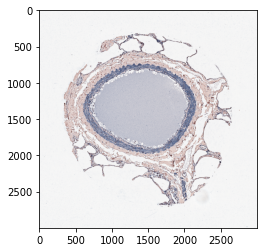

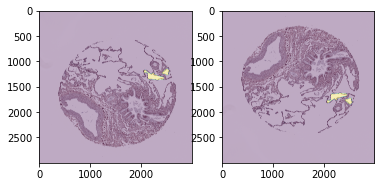

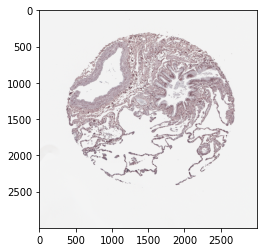

In [6]:
# for i in range(len(checked_img)):
#     plt.imshow(checked_img[i])
#     plt.show()
# plot the org image
# plot the intermidiate two images
# then plot the last image
# ;plt.imshow(checked_mask[check_point+2], alpha = 0.3)
check_point = 1
print(used_aug_list[check_point])
plt.imshow(org_img[check_point])
plt.show()
plt.subplot(1,2,1)
plt.imshow(checked_img[check_point-1]);plt.imshow(checked_mask[check_point-1], alpha = 0.3)

plt.subplot(1,2,2)
plt.imshow(checked_img[check_point]);plt.imshow(checked_mask[check_point], alpha = 0.3)
plt.show()
plt.imshow(auged_img[check_point-1])
plt.show()

['horflip' 'transpose']


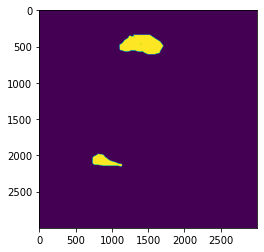

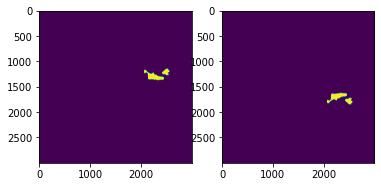

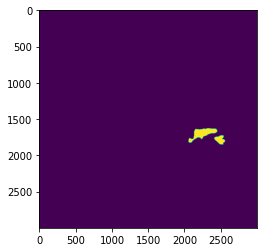

In [7]:
# plot the org image
# plot the intermidiate two images
# then plot the last image
# ;plt.imshow(checked_mask[check_point+2], alpha = 0.3)
check_point = 1
print(used_aug_list[check_point])
plt.imshow(org_mask[check_point])
plt.show()
plt.subplot(1,2,1)
plt.imshow(checked_mask[check_point-1])

plt.subplot(1,2,2)
plt.imshow(checked_mask[check_point])
plt.show()
plt.imshow(auged_msk[check_point-1])
plt.show()

uint8 uint8
img and mask unique values [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246

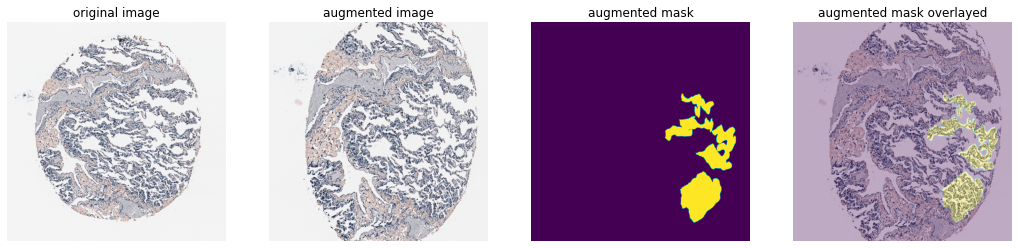

In [18]:
import numpy, imageio, elasticdeform
# X = numpy.zeros((200, 300))
# X[::10, ::10] = 1
img = cv2.cvtColor(tifffile.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"), cv2.COLOR_BGR2RGB)
msk = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)

print(msk.dtype, img.dtype)
print("img and mask unique values", np.unique(img),np.unique(msk))

# import package
import Augmentor

def elastic_deform(image, mask):
    """
    i/p image shape: (3000,3000,3)
    i/p mask shape: (3000,3000,1)

    o/p image shape: (3000,3000,3)
    o/p mask shape: (3000,3000,1)
    """
    p = Augmentor.DataPipeline([[img,msk]])

    p.shear(1, max_shear_left = 3, max_shear_right = 3)
    p.skew(0.4, 0.5)

    
    images_aug = p.sample(1)
    
    augmented_image = images_aug[0][0]
    augmented_mask = images_aug[0][1]

    return 

# initialize pipeline
p = Augmentor.DataPipeline([[img,msk]])

# apply augmentations
# p.rotate(1, max_left_rotation=3, max_right_rotation=3)
p.shear(1, max_shear_left = 3, max_shear_right = 3)
# p.zoom_random(1, percentage_area=0.9)
p.skew(0.4, 0.5)

# sample from augmentation pipeline
images_aug = p.sample(1)
# visualize augmented image
augmented_image = images_aug[0][0]
augmented_mask = images_aug[0][1]

# visualize augmented image and mask
fig, ax = plt.subplots(1,4, figsize = (18, 20))

ax[0].axis('off')
ax[0].imshow(img)
ax[0].set_title('original image')

ax[1].axis('off')
ax[1].imshow(augmented_image)
ax[1].set_title('augmented image')

ax[2].axis('off')
ax[2].imshow(augmented_mask)
ax[2].set_title('augmented mask')


ax[3].axis('off')
ax[3].imshow(augmented_image); ax[3].imshow(augmented_mask, alpha=0.3)
ax[3].set_title('augmented mask overlayed')
plt.show()

In [9]:
# plt.imshow(X_deformed)

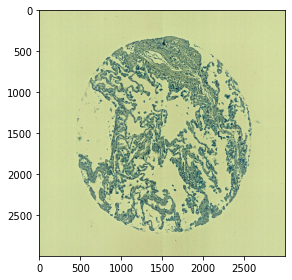

In [10]:
DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"
MASK_DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"

img_path = DIR + "/" +str(df_lung['id'].iloc[10]) + ".png"
mask_path = MASK_DIR + "/" +str(df_lung['id'].iloc[10]) + ".png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path,0)

# im_pil = Image.fromarray(img)
# img_with_bubbles = img_manip.add_bubbles(im_pil, alpha=0.55, maxWidth = 120, nBubbles = 150)
# np.array(img_with_bubbles)

h,w = mask.shape

seq = iaa.Sequential([
    iaa.AllChannelsCLAHE(clip_limit=(1, 10))
], random_order=True)

image, segmaps = seq(image=img, segmentation_maps=mask.reshape(1,h,w,1))
segmaps = segmaps.reshape(h,w)

plt.imshow(image);plt.imshow(segmaps, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
image_size = 512
TRAIN = '/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size'
class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k, d.get(k,0), d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]

        image = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, f'{d.id}.png')), cv2.COLOR_BGR2RGB)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width))
        #mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = 2)
        # print(mask.shape)
        
        image = image.astype(np.float32)/255
        #mask  = mask.astype(np.float32)/255
        mask = mask.astype(np.float32)

        # s = d.pixel_size/0.4 * (image_size/3000)
        # image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        # mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        print(image.shape, mask.shape)
        
        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)

        mask = np.expand_dims(mask, axis = 0)
        
        r ={}
        r['index']= index
        # r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image
        r['mask' ] = mask

        return r

In [12]:
def train_augment5b(image, mask, organ):
    
    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: horizontal_flip(image, mask),
        lambda image, mask: transpose_flip(image, mask),
        lambda image, mask: elastic_deform(image, mask),
    ], 2, p=[0.1, 0.2, 0.2, 0.5]): image, mask = fn(image, mask)

    # for fn in np.random.choice([
    #     # lambda image, mask: (image, mask),
    #     lambda image, mask: transpose_flip(image, mask),
    #     lambda image, mask: distort_aug(image, mask),
    #     # lambda image, mask: do_random_hsv(image, mask)
    # ], 1, p=[0.3, 0.7]): image, mask = fn(image, mask)

    # for fn in np.random.choice([
        # lambda image, mask: (image, mask),
        # lambda image, mask: bubble_aug(image, mask),
        # lambda image, mask: clahe_aug(image, mask),
        # lambda image, mask: sectioning_aug(image, mask),
        # lambda image, mask: stain_aug(image, mask)
    # ], 1, p=[0.1, 0.9]): image, mask = fn(image, mask)

    return image, mask


# def valid_augment5(image, mask, organ):
#     #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
#     return image, mask

# def train_augment5b(image, mask, organ):
#     # image, mask = cutout_custom(image, mask)
#     image, mask = do_random_flip(image, mask)
#     image, mask = do_random_rot90(image, mask)
    
#     for fn in np.random.choice([
#         lambda image, mask: (image, mask),
#         lambda image, mask: do_random_noise(image, mask, mag=0.1),
#         lambda image, mask: do_random_contast(image, mask, mag=0.40),
#         lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
#     ], 2): image, mask = fn(image, mask)

#     # for fn in np.random.choice([
#     #     lambda image, mask: transpose_flip(image, mask),
#     #     lambda image, mask: distort_aug(image, mask),
#     # ], 1): image, mask = fn(image, mask)

#     for fn in np.random.choice([
#         lambda image, mask: (image, mask),
#         lambda image, mask: horizontal_flip(image, mask),
#         lambda image, mask: transpose_flip(image, mask),
#         lambda image, mask: vertical_flip(image, mask)
#     ], 2, p=[0.05, 0.4, 0.25, 0.3]): image, mask = fn(image, mask)

#     return image, mask

In [13]:
tensor_list = ['mask', 'image', 'organ']
def null_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        if k in tensor_list:
            v = torch.stack(v)
        d[k] = v

    d['mask'] = d['mask'].unsqueeze(1)
    d['organ'] = d['organ'].reshape(-1)
    return d

df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")
df = df[df['organ']=='lung'].reset_index()
train_dataset = HubmapDataset(df)


# train_loader  = DataLoader(
#     train_dataset,
#     sampler = RandomSampler(train_dataset),
#     batch_size  = 4,
#     drop_last   = True,
#     num_workers = 8,
#     pin_memory  = False,
#     worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
#     collate_fn = null_collate,
# )

train_loader = torch.utils.data.DataLoader(
               dataset=train_dataset,
               batch_size=4,
               shuffle=False,
               num_workers=2)
# print(ds[10]['index'])
# plt.subplot(1,2,1)
# plt.imshow(ds[10]['image']);
# plt.imshow(ds[10]['image']); plt.imshow(ds[10]['mask'].reshape(3000,3000), alpha=0.3)
# plt.tight_layout()
# plt.show()
# plt.subplot(1,2,2)
# plt.imshow(ds[10]['mask'].reshape(3000.3000))
# plt.show()
# ds[10]['image'].shape


In [14]:
iter(train_loader)

TypeError: 'int' object is not callable

In [ ]:
items = next(iter(train_loader))
imgs = items["image"].permute((0, 2, 3, 1))
msks = items["mask"].permute((0, 2, 3, 1))
print(imgs.size(), msks.size())

# torch.unique(msks)

import matplotlib.pyplot as plt
def plot_batch(imgs, msks, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 2); plt.imshow(msks[idx])
        plt.title('mask', fontsize=15)
        plt.axis('OFF')
            
        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(msks[idx], alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

plot_batch(imgs, msks, size=3)

In [ ]:
ds[10]['image'].dtype

In [ ]:
# str(df.iloc[10]['id'])
id_ = df.iloc[10]['id']
image = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, f'{id_}.png')), cv2.COLOR_BGR2RGB); 
mask = cv2.cvtColor(cv2.imread(os.path.join("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks", f'{id_}.png')), cv2.COLOR_BGR2GRAY)

plt.imshow(image); plt.imshow(mask, alpha=0.3)
plt.show()

In [ ]:
from numpy.random import choice
  
sampleList = [100, 200, 300, 400, 500]
randomNumberList = choice(
  sampleList, 5, p=[0.05, 0.1, 0.15, 0.20, 0.5])
  
print(randomNumberList)